![Elo Merchant Category Recommendation](https://raw.githubusercontent.com/shejz/Elo-Merchant-Category-Recommendation/master/images/Elo_header.jpg?token=AJ6TIK3QHVXR44LV4RWEXQC6OB2U6)


This notebook is going to focus on Kaggle's **"Elo Merchant
Category Recommendation"** challenge that is about helping
understand customer loyalty using machine learning. Elo, a
large Brazilian payment brand (focused on debit and credit
cards), has built machine learning models to understand the
most important aspects in their customers’ lifecycle.

The motivation behind this challenge is to develop  machine learning models that identify and prescribe the most relevant opportunities for individuals, by predicting customer loyalty based on various data features arising from
customer data. Helping Elo to achieve this can improve its customers' payment experience and help reduce unwanted campaigns, to create the right experience for its customers.

## **Competition Objective**
- Predict any given customer's loyalty score based on the customer's past
  purchasing behaviour.
- We will be given a credit card data set to train their prediction model,
  then submit their preditions for credit cards in a test set.


## **Data Description**
The competition involves five datasets.


![Datasets](https://github.com/shejz/Elo-Merchant-Category-Recommendation/blob/master/images/five_datasets.jpg?raw=true)


- **train**
  - Training set. It includes the ID of the card, the year and month when the card was first activated `first_active_month` : ''YYYY-MM', month of first purchase.
  - 3 anonymous classification features (`feature_1`, `feature_2`, `feature_3`
  - `target` variables loyalty numerical score calculated 2 months after historical and evaluation period.
- **test**
  - The test set is the same as the training set, except that it has no target variables.
- **historical_transaction**
  - Before new merchants were recommended.
  - Historical transaction data, which contains transaction data for training and testing cards, all cards have at least 3 months of transaction records. 
  - Includes card ID, month_lag (relative to the number of months on the reference date, which is not well translated here), transactions date purchase_date, transaction authorized_flag, installment purchases, merchant_category_id, merchant category_id, merchant ID, transaction amount purchase_amount, transaction city and state, and 3 anonymous classification variables (category_1, category_2, category_3)
- **new_merchant_transaction**
  - After new merchants were recommended.
  - New merchant transaction data, the merchants included are the first consumption by the user in two months.   
  - The characteristics are consistent with the historical_transaction table.
  - The difference from the historical_transaction table is that the monthly_lag of the new transaction is 1 or 2, and the monthly_lag of the historical transaction -13 to 0. According to the definition of month_lag, the transaction date when month_lag is 0 is the so-called reference date.
- **merchants**
   - Merchant information. It is mainly the flow information of merchants, which did not help much in the competition.










<br>

The datasets are largely anonymized, and the meaning of the features are not elaborated.

External data are allowed.

## **Performance Regression Evaluation Metrics**
Root Mean Squared Error (`RMSE`) is the square root of the mean of the squared errors:


$
\begin{align}
RMSE = \sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}  &&  
\hat{y}_i :predicted\ loyalty\ score && {y}_i: actual\ loyalty\ score
\end{align}
$



In [0]:
# Load packages
import numpy as np
import pandas as pd
import random
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Configure seaborn
sns.set(style="white")


# Plotly
from plotly.offline import iplot
import plotly.graph_objs as go

import warnings 
warnings.filterwarnings('ignore')


In [0]:
# Function

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(20)

def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: random.randint(0, 255), range(3)))
    return color

# Text Annotation
def text_annotate(cnt):
    for i in cnt.patches:
        height = i.get_height()
        cnt.text(i.get_x() + i.get_width()/2., height,'%d' % int(height),ha='center',va='bottom')

def binarize(df,columns):
    for col in columns:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df


In [0]:
train        = pd.read_csv('/content/train.csv.zip', parse_dates=["first_active_month"])
test         = pd.read_csv('/content/test.csv.zip', parse_dates=["first_active_month"])
ht           = pd.read_csv('/content/historical_transactions.csv.zip',parse_dates=['purchase_date'])
merchant     = pd.read_csv('/content/merchants.csv.zip')
new_transactions = pd.read_csv('/content/new_merchant_transactions.csv.zip',parse_dates=["purchase_date"])
sample       = pd.read_csv('/content/sample_submission.csv.zip')

In [4]:
train        = reduce_mem_usage(train)
test         = reduce_mem_usage(test)
ht           = reduce_mem_usage(ht)
new_transactions = reduce_mem_usage(new_transactions)

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


## **Main data exploration**
Let's have a look at train data set.

| Variable Name | Description |
| --------------| ------------|
| card_id       | Unique card identifier |
| first_active_month | 'YYYY-MM', month of first purchase |
| feature_1 | Anonymized card categorical feature|
| feature_2 | Anonymized card categorical feature |
| feature_3 | Anonymized card categorical feature |
| target | Loyalty numerical score calculated 2 months after historical and evaluation period |


In [5]:
train['feature_1'] = train['feature_1'].astype('category')
train['feature_2'] = train['feature_2'].astype('category')
train['feature_3'] = train['feature_3'].astype('category')
train.head()

first_active_month          card_id feature_1 feature_2 feature_3    target
0         2017-06-01  C_ID_92a2005557         5         2         1 -0.820312
1         2017-01-01  C_ID_3d0044924f         4         1         0  0.392822
2         2016-08-01  C_ID_d639edf6cd         2         2         0  0.687988
3         2017-09-01  C_ID_186d6a6901         4         3         0  0.142456
4         2017-11-01  C_ID_cdbd2c0db2         1         3         0 -0.159790

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null category
feature_2             201917 non-null category
feature_3             201917 non-null category
target                201917 non-null float16
dtypes: category(3), datetime64[ns](1), float16(1), object(1)
memory usage: 4.0+ MB


### **Missing Value**


In [7]:
# checking train missing data
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total  Percent
target                  0      0.0
feature_3               0      0.0
feature_2               0      0.0
feature_1               0      0.0
card_id                 0      0.0
first_active_month      0      0.0

In [8]:
# checking test missing data
total = test.isnull().sum().sort_values(ascending = False)
percent = (test.isnull().sum()/test.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
first_active_month      1  0.000809
feature_3               0  0.000000
feature_2               0  0.000000
feature_1               0  0.000000
card_id                 0  0.000000

### **Loyalty score (target) distribution**

The `target` value has a special distribution. The target includes a normal distribution and **-33** outliers. However, the evaluation index is `RMSE`. Which very *sensitive to outliers*. It can be said that the prediction of outliers can determine success or failure.

In [9]:
from plotly.figure_factory import create_distplot

x = train['target'].head(50000).values.tolist()
hist_data = [x]
group_labels = ['target'] 

fig = create_distplot(hist_data, group_labels)
fig.update_layout(title_text="Loyalty score (target) distribution",
                  yaxis_title='Count',
                  xaxis_title="Value",
                  yaxis=dict(autorange=True,showgrid=False,zeroline=True),
                  showlegend=False,
                  paper_bgcolor='rgb(255,255,255)',
                  plot_bgcolor='rgb(255,255,255)')
fig.show()

In [10]:
print('There are {0} samples with target lower than -20.'.format(train.loc[train.target < -20].shape[0]))

There are 2207 samples with target lower than -20.


In [11]:
tr = train['target'].head(50000).values.tolist()
fig = go.Figure()
fig.add_trace(go.Box(
    y=tr,
    name="Data Points",
    jitter=0.1,
    pointpos=-1.8,
    boxpoints='all', # represent 50,000 data points
    marker_color='rgb(7,40,89)',
    line_color='rgb(7,40,89)'
))

fig.add_trace(go.Box(
    y=tr,
    name="Only Whiskers",
    boxpoints=False, # no data points
    marker_color='rgb(9,56,125)',
    line_color='rgb(9,56,125)'
))

fig.add_trace(go.Box(
    y=tr,
    name="Suspected Outliers",
    boxpoints='suspectedoutliers', # only suspected outliers
    marker=dict(
        color='rgb(8,81,156)',
        outliercolor='rgba(219, 64, 82, 0.6)',
        line=dict(
            outliercolor='rgba(219, 64, 82, 0.6)',
            outlierwidth=2)),
    line_color='rgb(8,81,156)'
))

fig.add_trace(go.Box(
    y=tr,
    name="Whiskers and Outliers",
    boxpoints='outliers', # only outliers
    marker_color='rgb(107,174,214)',
    line_color='rgb(107,174,214)'
))

fig.update_layout(title_text="Loyalty score (target) outliers",
                  yaxis=dict(autorange=True,showgrid=False,zeroline=True),
                  showlegend=False,
                  paper_bgcolor='rgb(255,255,255)',
                  plot_bgcolor='rgb(255,255,255)')


fig.show()


### **Features 1,2 and 3**
The training and test set were provided with three
anonymised categorical features `features_1`, `feature_2` and
`feature_3` 

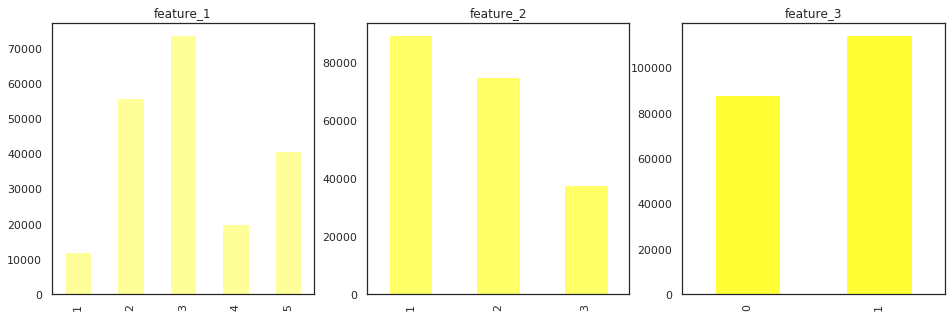

In [12]:
fig, ax = plt.subplots(1, 3, figsize = (16, 5))
train['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='#FFFF99', title='feature_1')
train['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='#FFFF66', title='feature_2')
train['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], color='#FFFF33', title='feature_3')

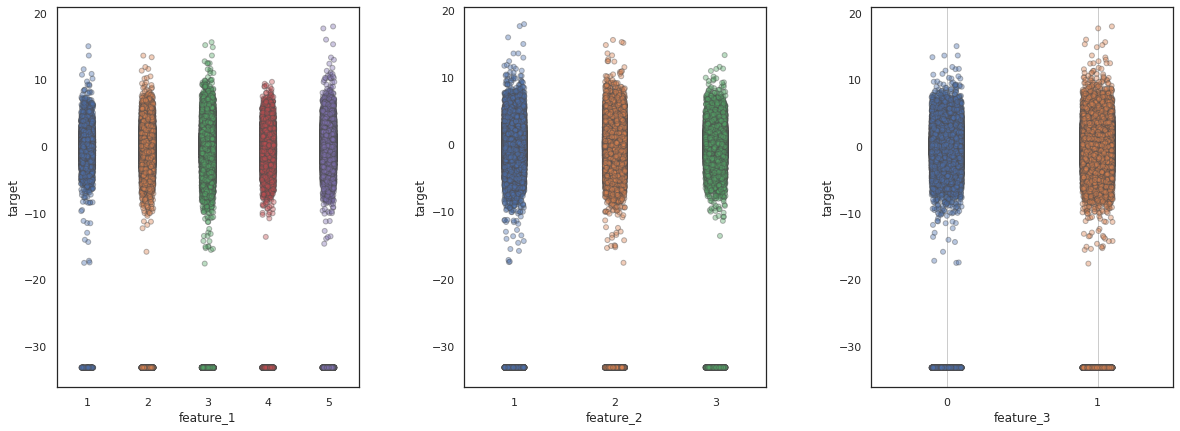

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
ax = sns.stripplot(x='feature_1', y='target', data=train, linewidth=1,ax=axes[0],jitter=True,  alpha=.40)
ax = sns.stripplot(x='feature_2', y='target', data=train, linewidth=1,ax=axes[1],jitter=True,  alpha=.40)
ax = sns.stripplot(x='feature_3', y='target', data=train, linewidth=1,ax=axes[2],jitter=True,  alpha=.40)

fig.subplots_adjust(wspace=0.35)
plt.gca().xaxis.grid(True)
plt.show()



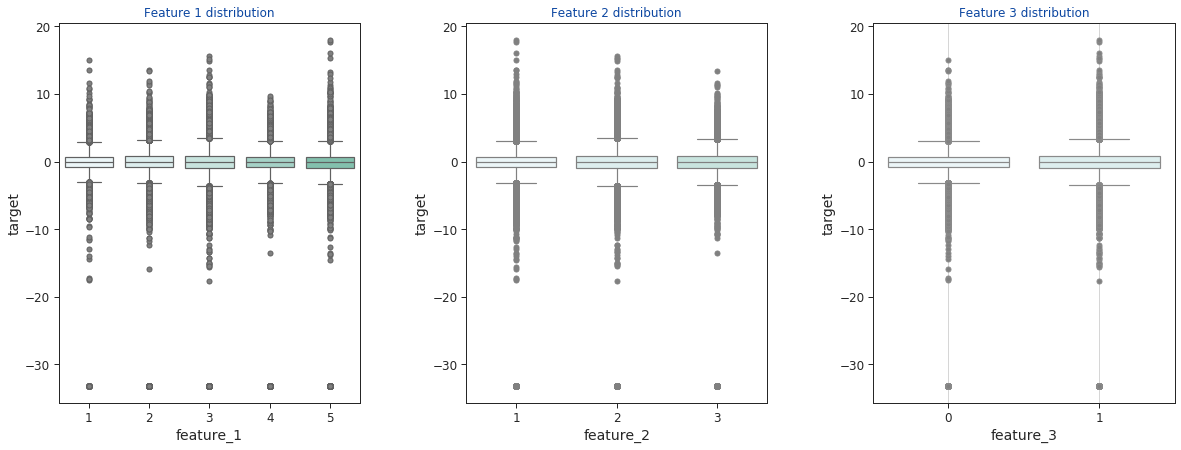

In [14]:
# Box-plot Style
sns.set_context("paper", rc={'xtick.labelsize': 12, 'ytick.labelsize': 12,'axes.titlesize':18,'axes.labelsize':14}) 
sns.set_style("ticks", {'xtick.major.size': 10, 'ytick.major.size': 10})

flierprops = dict(marker='o',markersize=5,markerfacecolor='gray')
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x='feature_1', y="target", data=train, palette=sns.color_palette("BuGn", 10), flierprops=flierprops, ax=axes[0])
axes[0].set_title('Feature 1 distribution', size=12, color="#0D47A1")

sns.boxplot(x='feature_2', y="target", data=train, palette=sns.color_palette("BuGn", 10), flierprops=flierprops, ax=axes[1])
axes[1].set_title('Feature 2 distribution', size=12, color="#0D47A1")

sns.boxplot(x='feature_3', y="target", data=train, palette=sns.color_palette("BuGn", 10), flierprops=flierprops, ax=axes[2])
axes[2].set_title('Feature 3 distribution', size=12, color="#0D47A1")

fig.subplots_adjust(wspace=0.35)
plt.gca().xaxis.grid(True)
plt.show()

### **First active month**

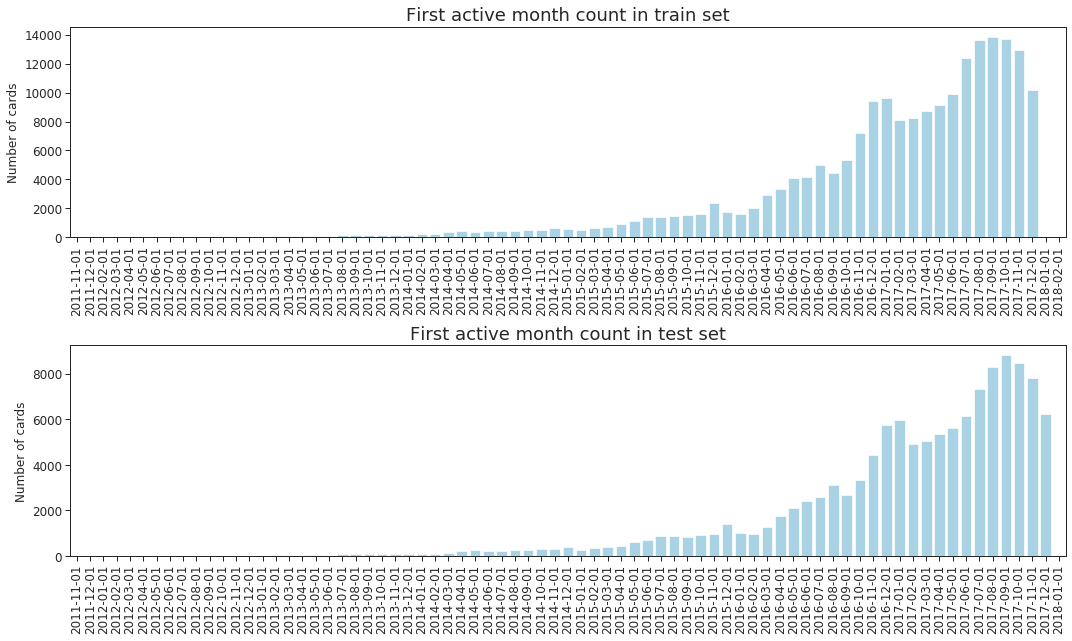

In [15]:
fig, ax = plt.subplots(2,1,figsize=(15,9))
cnt_srs = train['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='skyblue',ax=ax[0])
ax[0].set_ylabel('Number of cards', fontsize=12)
ax[0].set_title("First active month count in train set")
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=90)

cnt_srs = test['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='skyblue',ax=ax[1])
ax[1].set_ylabel('Number of cards', fontsize=12)
ax[1].set_title("First active month count in test set")
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=90)
fig.tight_layout()
plt.show()

`first_active_month` of train and test looks similiar.

The `new_merchant_transactions.csv` and `historical_transactions.csv`. These two files contain the same variables and the difference between the two tables only concern the position with respect to a reference date. Also, booleans features are made numeric.

## **Historical transactions**
Up to 3 months worth of historical transactions for each `card_id`

| Variable Name | Description |
| --------------| ------------|
|card_id | Card identifier|
|month_lag | Month lag to reference date|
|purchase_date | Purchase date|
|authorized_flag |'Y' if approved, 'N' if denied|
|installments | Number of installments of purchase|
|purchase_amount | Normalized purchase amount|
|subsector_id | Merchant category group identifier (anonymized )|
|merchant_category_id | Merchant category identifier (anonymized )|
|merchant_id | Merchant identifier (anonymized)|
|city_id | City identifier (anonymized )|
|state_id | State identifier (anonymized )|
|category_1 | Anonymized category|
|category_2 | Anonymized category|
|category_3 | Anonymized category|

In [16]:
ht.head()

authorized_flag          card_id  city_id  ... category_2  state_id subsector_id
0               Y  C_ID_4e6213e9bc       88  ...        1.0        16           37
1               Y  C_ID_4e6213e9bc       88  ...        1.0        16           16
2               Y  C_ID_4e6213e9bc       88  ...        1.0        16           37
3               Y  C_ID_4e6213e9bc       88  ...        1.0        16           34
4               Y  C_ID_4e6213e9bc       88  ...        1.0        16           37

[5 rows x 14 columns]

In [17]:
print(f'{ht.shape[0]} samples in data')

29112361 samples in data


In [18]:
ht.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int16
category_1              object
installments            int16
category_3              object
merchant_category_id    int16
merchant_id             object
month_lag               int8
purchase_amount         float32
purchase_date           datetime64[ns]
category_2              float16
state_id                int8
subsector_id            int8
dtypes: datetime64[ns](1), float16(1), float32(1), int16(3), int8(3), object(5)
memory usage: 1.7+ GB


In [19]:
r = re.compile(".*id")

# Filter categorical variables
categorical_columns =  ht.columns[ht.dtypes == object]

# Exclude ID column and Source
categorical_newList = list(filter(r.match, categorical_columns)) 
categorical_newList = [x for x in categorical_columns if x not in categorical_newList]

# Print frequency of categories
for col in categorical_newList:
    print('\nFrequency of categories for variable: %s'%col)
    print(ht.groupby(col)[col].agg({' ':'count'}))


Frequency of categories for variable: authorized_flag
                         
authorized_flag          
N                 2516909
Y                26595452

Frequency of categories for variable: category_1
                    
category_1          
N           27028332
Y            2084029

Frequency of categories for variable: category_3
                    
category_3          
A           15411747
B           11677522
C            1844933


In [0]:
numerical_features = ht.columns[ht.dtypes != object]

newlist = list(filter(r.match, numerical_features)) 
newlist = [x for x in numerical_features if x not in newlist]

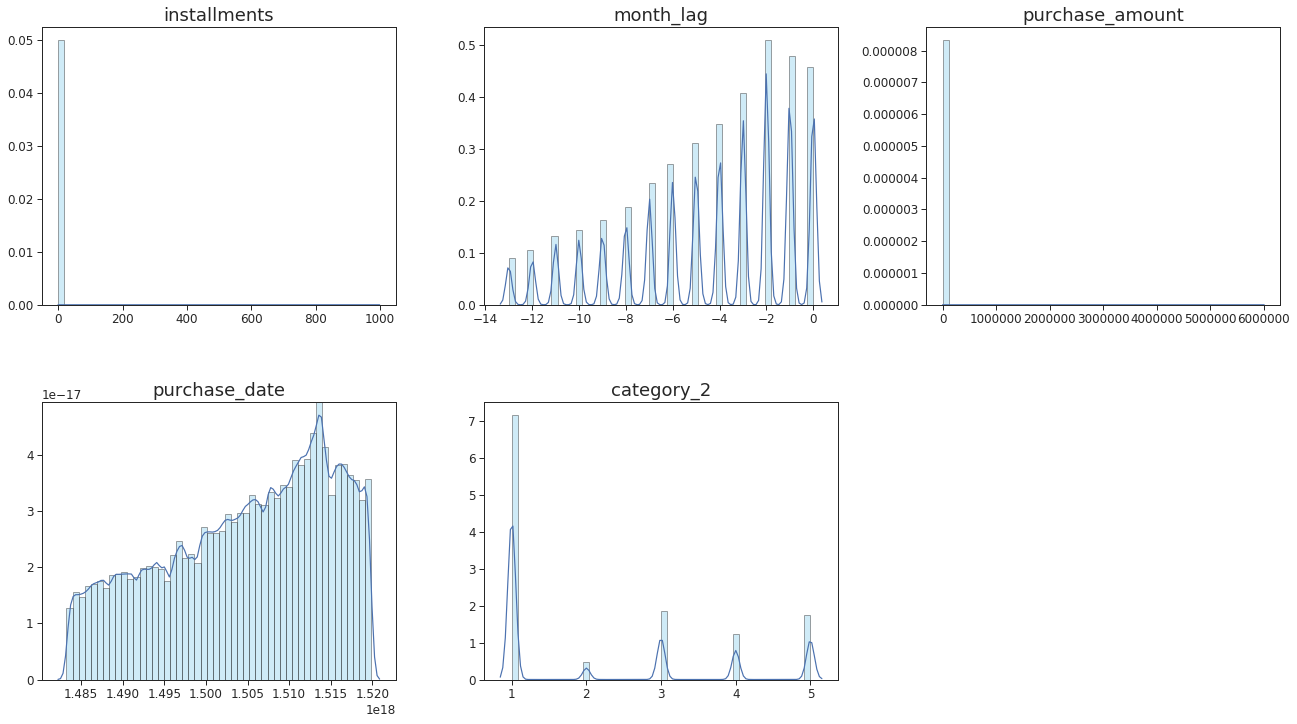

In [21]:
# Data Distribution Plot of all numerical features
def dist_plot(df, features, n_rows, n_cols):
    fig = plt.figure(figsize=(20,12))
    for i, features in enumerate(features):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        sns.distplot(df[features],hist_kws=dict(edgecolor="k", linewidth=1,color='skyblue'))
        plt.title(features)
        plt.xlabel('')
dist_plot(ht, newlist, 2, 3)
# Subplots spacing
plt.subplots_adjust(left=0.04, right=0.9, wspace=0.25, hspace=0.35)

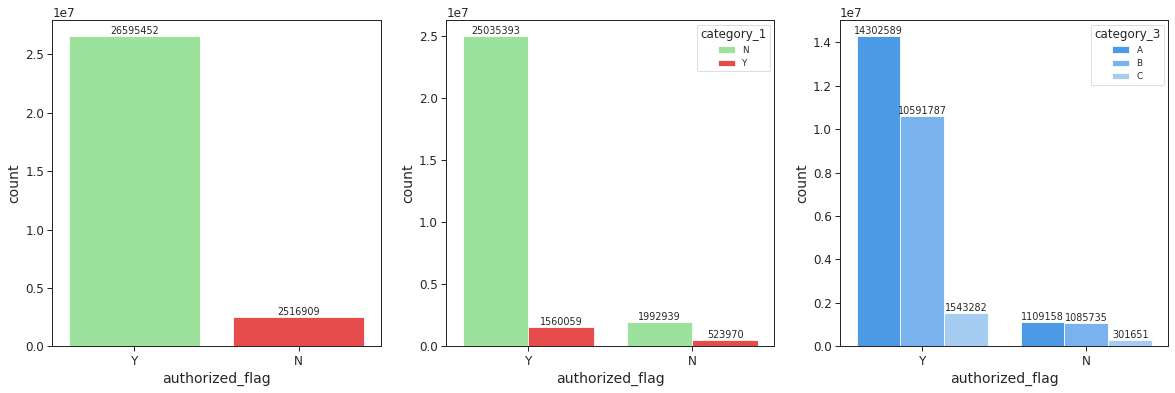

In [22]:
fig, ax = plt.subplots(1,3,figsize=(20,6))
cnt = sns.countplot(x='authorized_flag', data=ht, palette=['lightgreen', '#FF3333'],ax=ax[0])
text_annotate(cnt)
cnt = sns.countplot(x='authorized_flag', hue='category_1', data=ht, palette=['lightgreen', '#FF3333'],ax=ax[1])
text_annotate(cnt)
cnt = sns.countplot(x='authorized_flag', hue='category_3', data=ht, palette=["#3399FF","#66B2FF","#99CCFF"],ax=ax[2])
text_annotate(cnt)

In [0]:
features = ['authorized_flag', 'category_1']
ht = binarize(ht,features)
new_transactions = binarize(new_transactions,features)

### Cards with lowest and highest percentage of authorized transactions

In [24]:
print(f"At average {ht['authorized_flag'].mean() * 100:.4f}% transactions are authorized")

At average 91.3545% transactions are authorized


Cards with lowest and highest percentage of authorized transactions

In [25]:
autorized_card_rate = ht.groupby(['card_id'])['authorized_flag'].mean().sort_values()
autorized_card_rate.head()

card_id
C_ID_744d26ea32    0.030488
C_ID_bb8dd137c9    0.037037
C_ID_e56202cd39    0.042105
C_ID_4feacff118    0.050000
C_ID_c27b4f80f7    0.054545
Name: authorized_flag, dtype: float64

It seems that there are some cards, for which most of transactions were declined. Were this fraud transactions?

### Installment

In [26]:
ht['installments'].value_counts()

 0      15411747
 1      11677522
 2        666416
 3        538207
 4        179525
-1        178159
 6        132634
 10       118827
 5        116090
 12        55064
 8         20474
 7         10906
 9          5772
 11          830
 999         188
Name: installments, dtype: int64

Interesting. Most common number of installments are `0` and `1` which is expected. But **-1** and **999** are strange. I think that these values were used to fill in missing values.

In [27]:
def get_stats(at):
    return {'authorized transactions(%)':'{:.2f}%'.format(at.mean()*100)}
    
ht['authorized_flag'].groupby(ht['installments']).apply(get_stats)

installments                            
-1            authorized transactions(%)    88.57%
 0            authorized transactions(%)    92.80%
 1            authorized transactions(%)    90.70%
 2            authorized transactions(%)    88.40%
 3            authorized transactions(%)    86.23%
 4            authorized transactions(%)    81.99%
 5            authorized transactions(%)    80.92%
 6            authorized transactions(%)    77.97%
 7            authorized transactions(%)    69.32%
 8            authorized transactions(%)    69.24%
 9            authorized transactions(%)    66.37%
 10           authorized transactions(%)    70.20%
 11           authorized transactions(%)    66.02%
 12           authorized transactions(%)    65.37%
 999          authorized transactions(%)     3.19%
Name: authorized_flag, dtype: object

- On the other hand it seems that **999** could mean `fraud transactions`, considering only **3%** of these transactions were approved. 
- One more interesting thing is that *the higher the number of installments is, the lower is the approval rate*.

In [0]:
ht['installments'] = ht['installments'].astype('category')
ht['purchase_date'] = pd.to_datetime(ht['purchase_date'])

### Purchase amount
Sadly purchase_amount is normalized. Let's have a look at it nevertheless.

In [29]:
for i in [-1, 0]:
    n = ht.loc[ht['purchase_amount'] < i].shape[0]
    print(f"There are {n} transactions with purchase_amount less than {i}.")
for i in [0, 10, 100]:
    n = ht.loc[ht['purchase_amount'] > i].shape[0]
    print(f"There are {n} transactions with purchase_amount more than {i}.")

There are 0 transactions with purchase_amount less than -1.
There are 28036884 transactions with purchase_amount less than 0.
There are 1075467 transactions with purchase_amount more than 0.
There are 14924 transactions with purchase_amount more than 10.
There are 1183 transactions with purchase_amount more than 100.


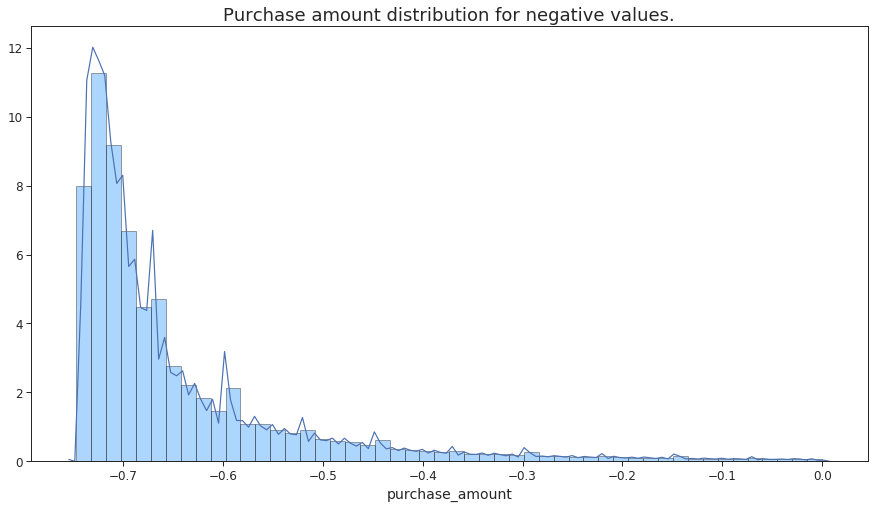

In [30]:
plt.figure(figsize=(15,8))
sns.distplot(ht.loc[ht['purchase_amount'] < 0, 'purchase_amount'],
            hist_kws=dict(edgecolor="k", lw=1, color='#3399FF'))
plt.title('Purchase amount distribution for negative values.')
plt.show()


It seems that almost all transactions have purchase amount in range (-1, 0). Quite a strong normalization and high outliers, which will need to be processed.

### Category
All categories are quite different

In [31]:
#ht['category_1'] = ht['category_1'].apply(lambda x: 0 if x == 'Y' else 1)
ht.groupby(['category_1']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

purchase_amount                        authorized_flag          
                      mean          std     count            mean       std
category_1                                                                 
0                 0.071540  1166.015991  27028332        0.926265  0.261339
1                -0.419327    22.087593   2084029        0.748578  0.433830

In [32]:
ht.groupby(['category_2']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

purchase_amount                        authorized_flag          
                      mean          std     count            mean       std
category_2                                                                 
1.0               0.149570  1548.714111  15177199        0.927505  0.259306
2.0              -0.165690    89.285767   1026535        0.906225  0.291515
3.0               0.180375   210.616104   3911795        0.918857  0.273055
4.0              -0.158951   141.945602   2618053        0.927634  0.259094
5.0              -0.104457   162.428787   3725915        0.934260  0.247826

In [33]:
map_dict = {'A': 0, 'B': 1, 'C': 2, 'nan': 3}
ht['category_3'] = ht['category_3'].apply(lambda x: map_dict[str(x)])
ht.groupby(['category_3']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

purchase_amount                        authorized_flag          
                      mean          std     count            mean       std
category_3                                                                 
0                 0.361926  1541.485107  15411747        0.928032  0.258436
1                -0.404556   104.062691  11677522        0.907024  0.290399
2                 0.106023    24.047655   1844933        0.836498  0.369824
3                 0.058447     2.191567    178159        0.885692  0.318186

In [34]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print(f"There are {ht[col].nunique()} unique values in {col}.")

There are 308 unique values in city_id.
There are 327 unique values in merchant_category_id.
There are 326311 unique values in merchant_id.
There are 25 unique values in state_id.
There are 41 unique values in subsector_id.
